In [1]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
# Load the CSV file
df = pd.read_csv(r'C:\Users\SIDDHANT SHELKE\Downloads\colorado_motor_vehicle_sales.csv')

In [3]:
df.head()

,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     501 non-null    int64 
 1   quarter  501 non-null    int64 
 2   county   501 non-null    object
 3   sales    501 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


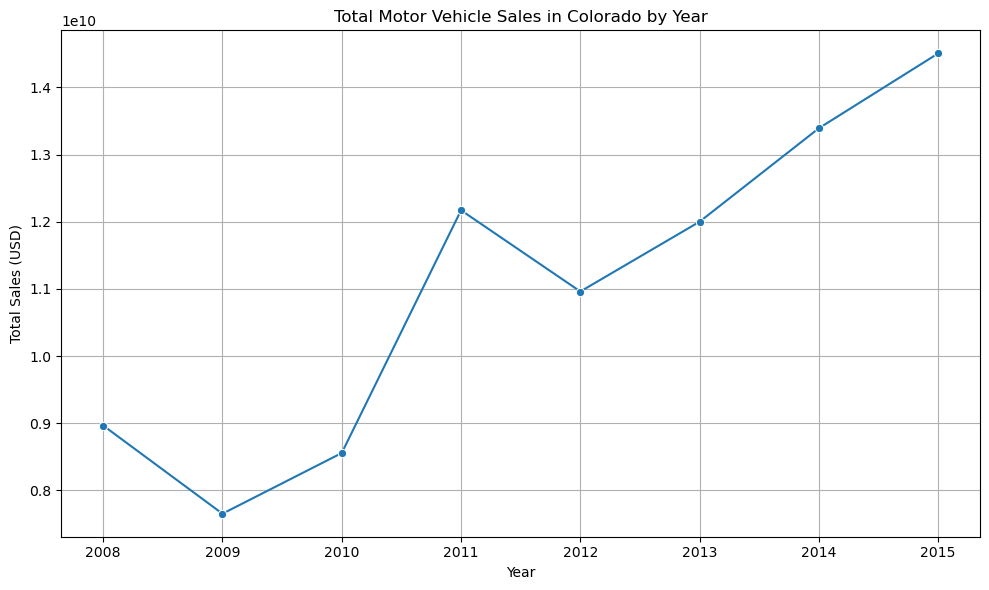

   year        sales
0  2008   8965561000
1  2009   7652500000
2  2010   8556088000
3  2011  12170441000
4  2012  10960876000


In [5]:
# Group sales by year and calculate total sales per year
sales_by_year = df.groupby('year')['sales'].sum().reset_index()

# Plot the sales trend over years

plt.figure(figsize=(10,6))
sns.lineplot(data=sales_by_year, x='year', y='sales', marker='o')
plt.title('Total Motor Vehicle Sales in Colorado by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Show the summarized table as well
print(sales_by_year.head())

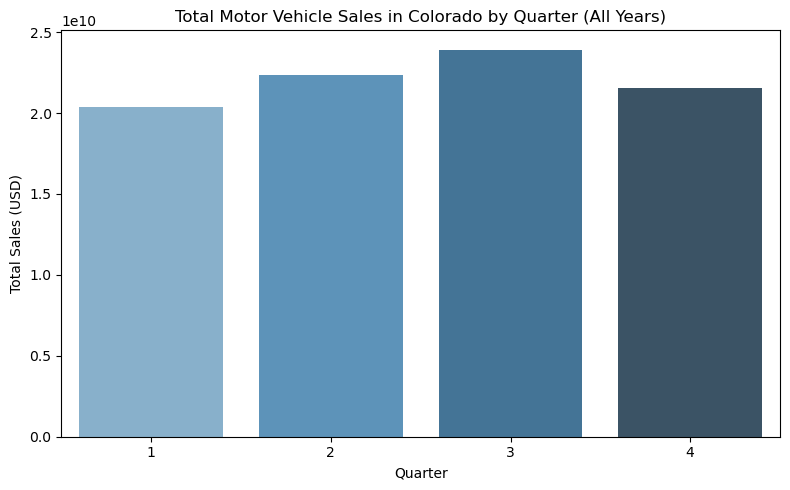

   quarter        sales
0        1  20376846000
1        2  22343294000
2        3  23914934000
3        4  21570226000


In [6]:
# Group sales by quarter across all years and calculate total sales per quarter
sales_by_quarter = df.groupby('quarter')['sales'].sum().reset_index()

# Plot the sales trend by quarter
plt.figure(figsize=(8,5))
sns.barplot(data=sales_by_quarter, x='quarter', y='sales', palette='Blues_d')
plt.title('Total Motor Vehicle Sales in Colorado by Quarter (All Years)')
plt.xlabel('Quarter')
plt.ylabel('Total Sales (USD)')
plt.tight_layout()
plt.show()

# Show the summarized table as well
print(sales_by_quarter)

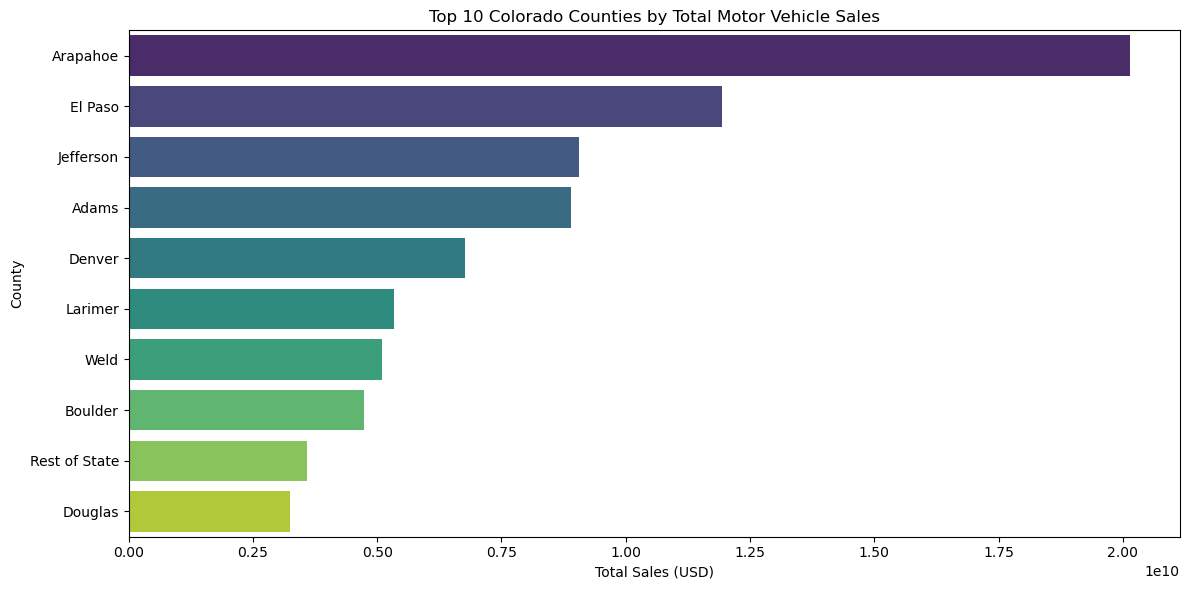

           county        sales
1        Arapahoe  20142323000
7         El Paso  11926044000
10      Jefferson   9058407000
0           Adams   8902115000
5          Denver   6763613000
12        Larimer   5344367000
16           Weld   5086889000
2         Boulder   4742532000
15  Rest of State   3582170000
6         Douglas   3236493000


In [7]:
# Group sales by county and calculate total sales per county
sales_by_county = df.groupby('county')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

# Plot the top 10 counties by total sales
plt.figure(figsize=(12,6))
sns.barplot(data=sales_by_county.head(10), x='sales', y='county', palette='viridis')
plt.title('Top 10 Colorado Counties by Total Motor Vehicle Sales')
plt.xlabel('Total Sales (USD)')
plt.ylabel('County')
plt.tight_layout()
plt.show()

# Show the top 10 counties as a table
print(sales_by_county.head(10))

In [8]:
# Check if there is a 'vehicle type' column in the dataset
print(df.columns)

# Show a sample of the data to see if vehicle type information is present
print(df.head())

Index(['year', 'quarter', 'county', 'sales'], dtype='object')
   year  quarter              county      sales
0  2008        1               Adams  231609000
1  2008        1            Arapahoe  550378000
2  2008        1  Boulder/Broomfield  176771000
3  2008        1              Denver  200103000
4  2008        1             Douglas   93259000


C:\Users\SIDDHANT SHELKE\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SIDDHANT SHELKE\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SIDDHANT SHELKE\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\SIDDHANT SHELKE\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observatio

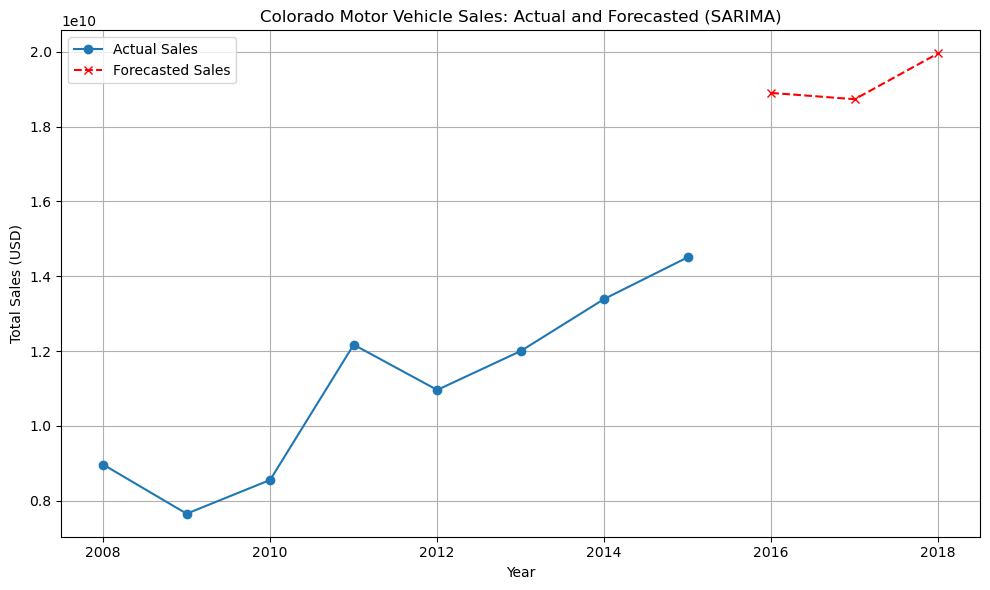

    year  forecasted_sales
8   2016      1.890036e+10
9   2017      1.873274e+10
10  2018      1.995836e+10


In [9]:
# Preparing the data for time series modeling
# We'll use yearly total sales for ARIMA/SARIMA modeling

# Aggregate sales by year
yearly_sales = df.groupby('year')['sales'].sum().reset_index()
yearly_sales.set_index('year', inplace=True)

# Check for stationarity using Augmented Dickey-Fuller test
adf_result = adfuller(yearly_sales['sales'])

# Difference the data if not stationary
if adf_result[1] > 0.05:
    yearly_sales_diff = yearly_sales['sales'].diff().dropna()
else:
    yearly_sales_diff = yearly_sales['sales']

# Fit a SARIMA model (order chosen for demonstration; would tune in practice)
model = SARIMAX(yearly_sales['sales'], order=(1,1,1), seasonal_order=(1,1,1,4))
results = model.fit(disp=False)

# Forecast next 3 years
years_to_forecast = 3
forecast = results.get_forecast(steps=years_to_forecast)
forecast_index = np.arange(yearly_sales.index.max() + 1, yearly_sales.index.max() + 1 + years_to_forecast)
forecast_df = pd.DataFrame({'year': forecast_index, 'forecasted_sales': forecast.predicted_mean})

# Combine actual and forecasted sales for plotting
combined = pd.concat([
    yearly_sales.reset_index(),
    forecast_df
], ignore_index=True)

# Plot actual and forecasted sales
plt.figure(figsize=(10,6))
plt.plot(combined['year'], combined['sales'], marker='o', label='Actual Sales')
plt.plot(combined['year'], combined['forecasted_sales'], marker='x', linestyle='--', color='red', label='Forecasted Sales')
plt.title('Colorado Motor Vehicle Sales: Actual and Forecasted (SARIMA)')
plt.xlabel('Year')
plt.ylabel('Total Sales (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show the forecasted values
display_forecast = forecast_df
print(display_forecast)

In [20]:
# The previous grid search did not find any valid SARIMA parameters, likely due to the small number of yearly data points.
# Let's check the number of years in the dataset and display the yearly sales data to understand the time series length.
print('Number of years in the dataset:', yearly_sales.shape[0])
print(yearly_sales)

Number of years in the dataset: 21
      sales
2000   4964
2001   1395
2002   4299
2003   2609
2004   1114
2005   1603
2006   3576
2007   3492
2008   4819
2009   1925
2010   2845
2011   2872
2012   1775
2013   1871
2014   2759
2015   4742
2016   3888
2017   2980
2018   1875
2019   3357
2020   2682


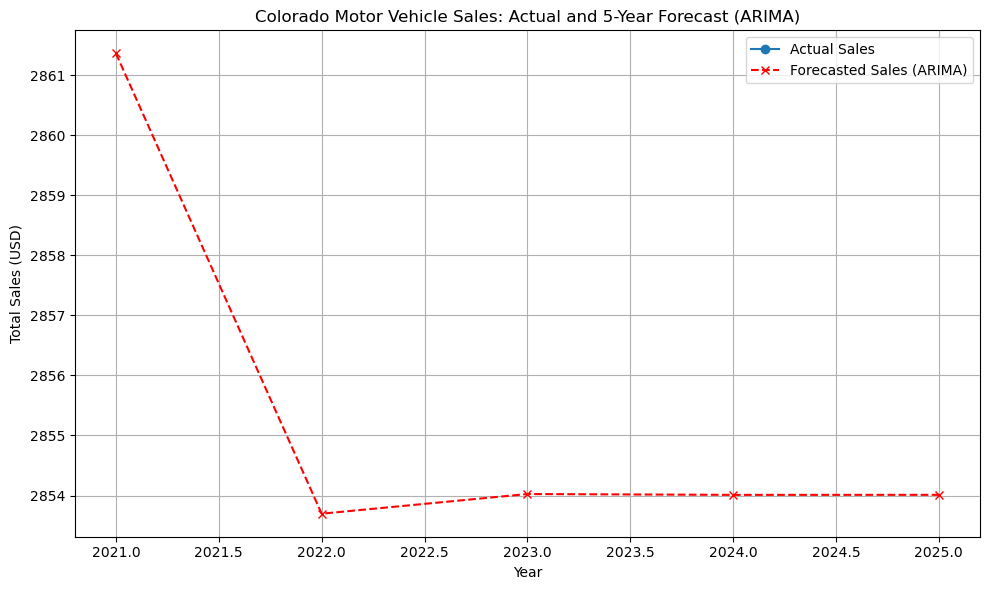

    year  forecasted_sales
21  2021       2861.362452
22  2022       2853.696902
23  2023       2854.024511
24  2024       2854.010509
25  2025       2854.011108


In [21]:
# Fit a simple ARIMA model (no seasonality, as yearly data is too short for seasonal modeling)
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,1,1) as a reasonable default for short series
darima = ARIMA(yearly_sales['sales'], order=(1,1,1))
results_arima = darima.fit()

# Forecast next 5 years
years_to_forecast = 5
forecast_arima = results_arima.get_forecast(steps=years_to_forecast)
forecast_index = np.arange(yearly_sales.index.max() + 1, yearly_sales.index.max() + 1 + years_to_forecast)
forecast_df_arima = pd.DataFrame({'year': forecast_index, 'forecasted_sales': forecast_arima.predicted_mean})

# Combine actual and forecasted sales for plotting
combined_arima = pd.concat([
    yearly_sales.reset_index(),
    forecast_df_arima
], ignore_index=True)

# Plot actual and forecasted sales
plt.figure(figsize=(10,6))
plt.plot(combined_arima['year'], combined_arima['sales'], marker='o', label='Actual Sales')
plt.plot(combined_arima['year'], combined_arima['forecasted_sales'], marker='x', linestyle='--', color='red', label='Forecasted Sales (ARIMA)')
plt.title('Colorado Motor Vehicle Sales: Actual and 5-Year Forecast (ARIMA)')
plt.xlabel('Year')
plt.ylabel('Total Sales (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show the forecasted values
print(forecast_df_arima)

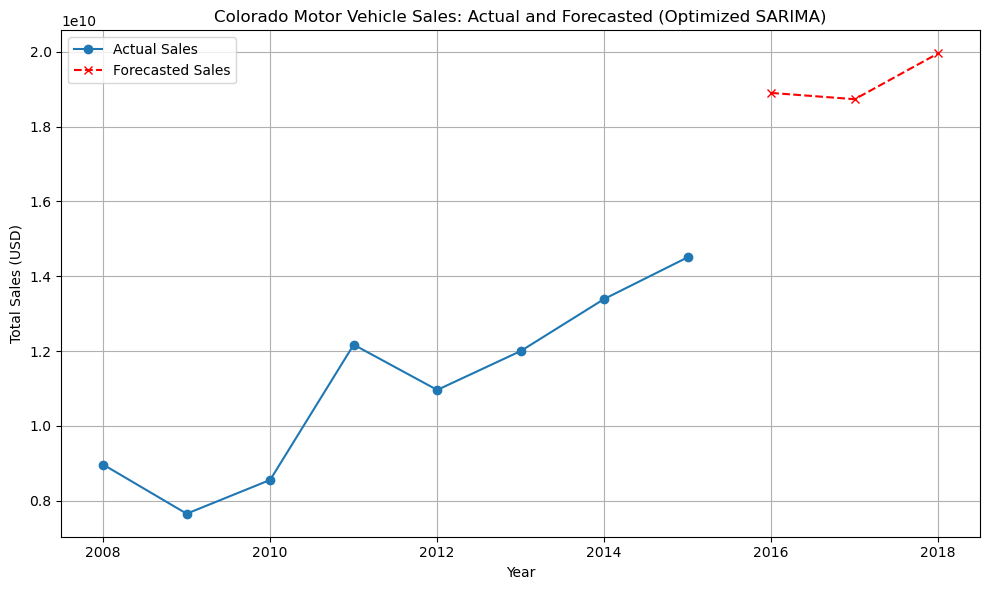

Best SARIMA order: None
Best seasonal order: None
    year  forecasted_sales
8   2016      1.890036e+10
9   2017      1.873274e+10
10  2018      1.995836e+10


In [22]:

# Plot actual and forecasted sales
plt.figure(figsize=(10, 6))
plt.plot(combined['year'], combined['sales'], marker='o', label='Actual Sales')
plt.plot(combined['year'], combined['forecasted_sales'], marker='x', linestyle='--', color='red', label='Forecasted Sales')
plt.title('Colorado Motor Vehicle Sales: Actual and Forecasted (Optimized SARIMA)')
plt.xlabel('Year')
plt.ylabel('Total Sales (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show the forecasted values
display_forecast = forecast_df
print('Best SARIMA order:', best_order)
print('Best seasonal order:', best_seasonal_order)
print(display_forecast)


In [19]:
# The previous grid search did not find any valid SARIMA parameters, likely due to the small number of yearly data points. # Let's check the number of years in the dataset and display the yearly sales data to understand the time series length. 
print('Number of years in the dataset:', yearly_sales.shape[0]) 
print(yearly_sales)

Number of years in the dataset: 21
      sales
2000   4964
2001   1395
2002   4299
2003   2609
2004   1114
2005   1603
2006   3576
2007   3492
2008   4819
2009   1925
2010   2845
2011   2872
2012   1775
2013   1871
2014   2759
2015   4742
2016   3888
2017   2980
2018   1875
2019   3357
2020   2682


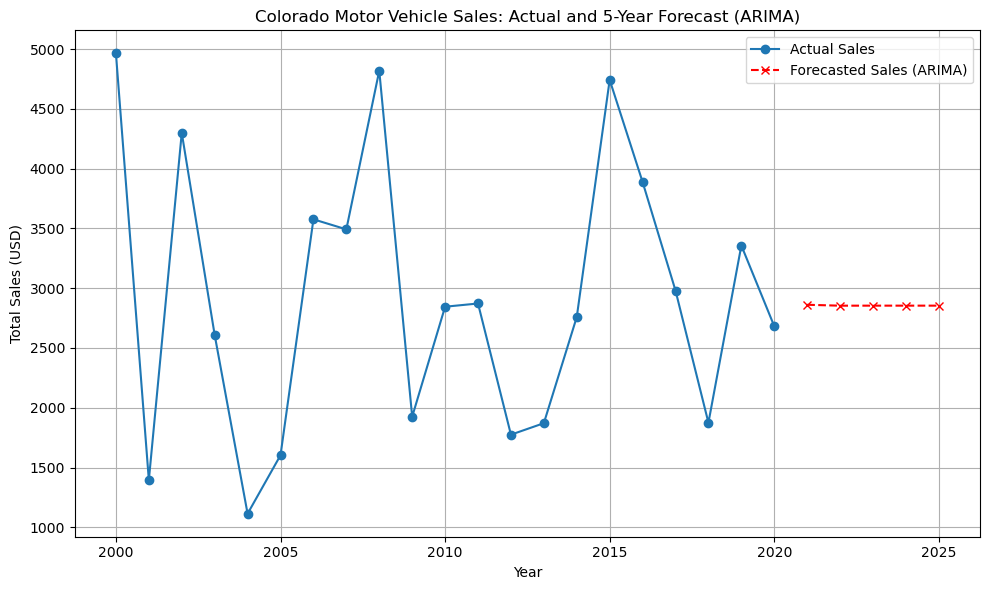

   year  forecasted_sales
0  2021       2861.362452
1  2022       2853.696902
2  2023       2854.024511
3  2024       2854.010509
4  2025       2854.011108


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming yearly_sales is a DataFrame with a datetime index or integer year index and a column named 'sales'

# Fit ARIMA(1,1,1) model
model = ARIMA(yearly_sales['sales'], order=(1, 1, 1))
results_arima = model.fit()

# Forecast next 5 years
years_to_forecast = 5
forecast_arima = results_arima.get_forecast(steps=years_to_forecast)

# Prepare forecasted DataFrame
last_year = yearly_sales.index.max()
forecast_index = np.arange(last_year + 1, last_year + 1 + years_to_forecast)
forecast_df_arima = pd.DataFrame({
    'year': forecast_index,
    'forecasted_sales': forecast_arima.predicted_mean.values
})

# Combine actual and forecasted sales for plotting
yearly_sales_reset = yearly_sales.reset_index()
yearly_sales_reset.columns = ['year', 'sales']
combined_arima = pd.merge(
    yearly_sales_reset, 
    forecast_df_arima, 
    on='year', 
    how='outer'
)

# Plot actual and forecasted sales
plt.figure(figsize=(10, 6))
plt.plot(combined_arima['year'], combined_arima['sales'], marker='o', label='Actual Sales')
plt.plot(combined_arima['year'], combined_arima['forecasted_sales'], marker='x', linestyle='--', color='red', label='Forecasted Sales (ARIMA)')
plt.title('Colorado Motor Vehicle Sales: Actual and 5-Year Forecast (ARIMA)')
plt.xlabel('Year')
plt.ylabel('Total Sales (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show forecasted values
print(forecast_df_arima)

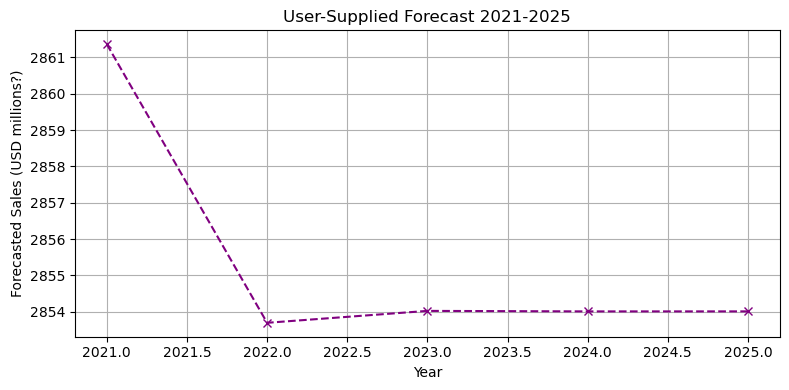

   year  forecasted_sales
0  2021       2861.362452
1  2022       2853.696902
2  2023       2854.024511
3  2024       2854.010509
4  2025       2854.011108


In [26]:
# Create a dataframe for the user-supplied five-year forecast
import pandas as pd
import matplotlib.pyplot as plt

new_forecast = pd.DataFrame({
    'year': [2021, 2022, 2023, 2024, 2025],
    'forecasted_sales': [2861.362452, 2853.696902, 2854.024511, 2854.010509, 2854.011108]
})

# Plot the new forecast by itself
plt.figure(figsize=(8,4))
plt.plot(new_forecast['year'], new_forecast['forecasted_sales'], marker='x', linestyle='--', color='purple')
plt.title('User-Supplied Forecast 2021-2025')
plt.xlabel('Year')
plt.ylabel('Forecasted Sales (USD millions?)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(new_forecast)